# Conditioned LSTM

In [1]:
import random

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import gensim
from gensim.models import KeyedVectors
from gensim.models.lsimodel import LsiModel
from gensim.corpora.dictionary import Dictionary

D:\giuse\Conda\envs\thesis\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
with open('data/tokenized.txt','r') as f:
    tokenized = eval(f.read())
    
with open('data/tokens.txt','r') as f:
    tokens = eval(f.read())

In [3]:
x_arr = np.load('data/x.npy')
y_arr = np.load('data/y.npy')

In [4]:
def get_batches(arr_x, arr_y, batch_size):
    
    pos = 0
    
    for n in range(batch_size, arr_x.shape[0], batch_size):
        x = arr_x[pos:n]
        y = arr_y[pos:n]
        pos = n
        yield x, y

## Word2Vec

In [5]:
w2v_model = gensim.models.KeyedVectors.load("w2v.model", mmap='r')

In [6]:
vocab_size, emdedding_size = w2v_model.wv.vectors.shape
vocab_size, emdedding_size

(17862, 100)

In [7]:
embedding_size = w2v_model.wv.vectors.shape[1]
embedding_size

100

In [8]:
w2v_tensors = torch.FloatTensor(w2v_model.wv.vectors)

## Topic Modelling

### Corpus

In [9]:
dct = Dictionary(tokenized)
dct.filter_extremes(no_below=5, no_above=0.3)

In [10]:
len(dct)

5485

In [11]:
print(dct)

Dictionary(5485 unique tokens: ['across', 'all', 'annotation', 'arabic', 'baselines']...)


In [12]:
corpus = [dct.doc2bow(a) for a in tokenized]

### Latent Semantic Analysis (LSA)

In [13]:
n_hidden = 256
batch_size = 64
n_layers = 3

In [14]:
lsi = LsiModel(corpus, id2word=dct, num_topics=n_hidden, decay=0.2)

In [15]:
lsi.show_topics(5)

[(0,
  '0.862*"e" + 0.293*"de" + 0.163*"d" + 0.125*"les" + 0.122*"la" + 0.121*"des" + 0.108*"l" + 0.095*"et" + 0.087*"s" + 0.081*"le"'),
 (1,
  '0.177*"word" + 0.151*"text" + 0.137*"learning" + 0.135*"using" + 0.134*"information" + 0.132*"it" + 0.130*"performance" + 0.126*"tasks" + 0.122*"training" + 0.121*"or"'),
 (2,
  '-0.777*"word" + -0.237*"embeddings" + -0.202*"words" + 0.142*"text" + -0.107*"languages" + 0.100*"domain" + 0.096*"knowledge" + 0.094*"dataset" + 0.091*"question" + 0.083*"training"'),
 (3,
  '0.663*"translation" + 0.271*"english" + 0.271*"machine" + 0.168*"nmt" + 0.158*"languages" + -0.126*"information" + 0.118*"parallel" + 0.117*"mt" + -0.110*"knowledge" + 0.095*"source"'),
 (4,
  '-0.305*"corpus" + 0.185*"neural" + 0.183*"training" + -0.180*"languages" + 0.162*"translation" + -0.154*"speech" + 0.152*"tasks" + 0.144*"propose" + -0.135*"system" + 0.134*"sentence"')]

In [16]:
lsi.show_topic(3, topn=10)

[('translation', 0.6633340577028972),
 ('english', 0.2709217211537034),
 ('machine', 0.2705053184612935),
 ('nmt', 0.16817154915592414),
 ('languages', 0.15796281011927574),
 ('information', -0.12648445062567976),
 ('parallel', 0.11846450616842508),
 ('mt', 0.11744000289966029),
 ('knowledge', -0.11030224023449138),
 ('source', 0.09548638796378722)]

In [17]:
trans_topics = np.transpose(lsi.projection.u)

### Principal Component Analysis (PCA)

In [18]:
pca_topics = PCA(n_components=n_layers*batch_size, svd_solver='full').fit_transform(trans_topics)

In [19]:
pca_trans = np.transpose(pca_topics)

## Models

### Conditioned LSTM

In [20]:
class ConditionedLSTM(nn.Module):
    
    def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.2, lr=0.001):
        super().__init__()

        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.emb_layer = nn.Embedding(vocab_size, embedding_size)

        # LSTM
        self.lstm = nn.LSTM(embedding_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # fully-connected layer
        self.fc = nn.Linear(n_hidden, vocab_size)      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        
        x = x.long()

        # pass input through embedding layer
        embedded = self.emb_layer(x)     
        
        # get outputs and new hidden state from the lstm
        lstm_output, hidden = self.lstm(embedded, hidden)
        
        # pass through a dropout layer
        out = self.dropout(lstm_output)
        
        # flatten out
        out = out.reshape(-1, self.n_hidden) 

        # put "out" through the fully-connected layer
        out = self.fc(out)

        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' initializes hidden state '''

        hidden = (torch.FloatTensor(pca_trans.reshape(self.n_layers, batch_size, self.n_hidden)),
                 torch.ones(self.n_layers, batch_size, self.n_hidden))

        return hidden

In [22]:
# instantiate the model
cond_lstm = ConditionedLSTM(n_hidden=n_hidden, n_layers=n_layers)

print(cond_lstm)

ConditionedLSTM(
  (emb_layer): Embedding(17862, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=17862, bias=True)
)


### Condtiioned LSTM + Word2Vec

In [35]:
class CondLSTM_Word2Vec(nn.Module):
    
    def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.2, lr=0.001):
        super().__init__()

        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.emb_layer = nn.Embedding.from_pretrained(w2v_tensors)

        # LSTM
        self.lstm = nn.LSTM(embedding_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # fully-connected layer
        self.fc = nn.Linear(n_hidden, vocab_size)      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        
        x = x.long()

        # pass input through embedding layer
        embedded = self.emb_layer(x)     
        
        # get outputs and new hidden state from the lstm
        lstm_output, hidden = self.lstm(embedded, hidden)
        
        # pass through a dropout layer
        out = self.dropout(lstm_output)
        
        # flatten out
        out = out.reshape(-1, self.n_hidden) 

        # put "out" through the fully-connected layer
        out = self.fc(out)

        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' initializes hidden state '''

        hidden = (torch.FloatTensor(pca_trans.reshape(self.n_layers, batch_size, self.n_hidden)),
                 torch.ones(self.n_layers, batch_size, self.n_hidden))

        return hidden

In [36]:
# instantiate the model
cond_lstm_w2v = CondLSTM_Word2Vec(n_hidden=n_hidden, n_layers=n_layers)

print(cond_lstm_w2v)

CondLSTM_Word2Vec(
  (emb_layer): Embedding(17862, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=17862, bias=True)
)


## Training

In [23]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [25]:
def train(model, epochs=10, batch_size=32, lr=0.001, clip=1, print_every=32):
    
    # optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # loss criterion
    criterion = nn.CrossEntropyLoss()
    
    # loss values
    losses = []

    model.train()

    for e in range(epochs):
        
        batch = 0
        
        epoch_loss= []
        
        for x, y in get_batches(x_arr, y_arr, batch_size):
            
            batch += 1
            
            # initialize hidden state
            h = model.init_hidden(batch_size)
            
            # convert numpy arrays to PyTorch arrays
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            # detach hidden states
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            model.zero_grad()
            
            # get the output from the model
            output, h = model(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(-1).long())

            # back-propagate error
            loss.backward()
            
            # add current batch loss to epoch loss list
            epoch_loss.append(loss.item())

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # update weigths
            opt.step()    
            
            
            # show epoch - batch - loss every n batches
            if batch % print_every == 0:
                
                tot_batches = int(x_arr.shape[0] / batch_size)
            
                print("Epoch: {}/{} -".format(e+1, epochs),
                      "Batch: {}/{} -".format(batch, tot_batches),
                      "Loss: {}".format(loss))
        
        # print loss at the end of each epoch
        print("Epoch: {}/{} -".format(e+1, epochs),
              "Loss: {}".format(loss))
        
        # save average epoch loss
        losses.append(sum(epoch_loss)/len(epoch_loss))
        
    my_plot(np.linspace(1, epochs, epochs).astype(int), losses)

In [73]:
epochs = 30
path = 'weights/cond_lstm_w2v.pt'
loss = 0.2

optimizer = torch.optim.Adam(cond_lstm_w2v.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [64]:
# save checkpoints
torch.save({
            'epoch': epochs,
            'model_state_dict': cond_lstm_w2v.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion
            }, path)

D:\giuse\Conda\envs\thesis\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1/30 - Batch: 5/91 - Loss: 9.636506080627441
Epoch: 1/30 - Batch: 10/91 - Loss: 7.962486743927002
Epoch: 1/30 - Batch: 15/91 - Loss: 7.210313320159912
Epoch: 1/30 - Batch: 20/91 - Loss: 7.115902900695801
Epoch: 1/30 - Batch: 25/91 - Loss: 7.133000373840332
Epoch: 1/30 - Batch: 30/91 - Loss: 7.069431781768799
Epoch: 1/30 - Batch: 35/91 - Loss: 7.065545082092285
Epoch: 1/30 - Batch: 40/91 - Loss: 6.834764003753662
Epoch: 1/30 - Batch: 45/91 - Loss: 6.977421283721924
Epoch: 1/30 - Batch: 50/91 - Loss: 6.952078342437744
Epoch: 1/30 - Batch: 55/91 - Loss: 6.928534030914307
Epoch: 1/30 - Batch: 60/91 - Loss: 6.860357761383057
Epoch: 1/30 - Batch: 65/91 - Loss: 6.889596462249756
Epoch: 1/30 - Batch: 70/91 - Loss: 6.962825298309326
Epoch: 1/30 - Batch: 75/91 - Loss: 7.319894790649414
Epoch: 1/30 - Batch: 80/91 - Loss: 6.860445499420166
Epoch: 1/30 - Batch: 85/91 - Loss: 6.941708564758301
Epoch: 1/30 - Batch: 90/91 - Loss: 6.784283638000488
Epoch: 1/30 - Loss: 8.893921852111816
Epoch: 2/

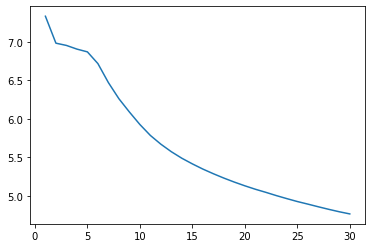

In [39]:
train(cond_lstm_w2v, batch_size=batch_size, epochs=epochs, print_every=5)

Epoch: 1/10 - Batch: 5/91 - Loss: 9.678860664367676
Epoch: 1/10 - Batch: 10/91 - Loss: 8.069537162780762
Epoch: 1/10 - Batch: 15/91 - Loss: 7.24202823638916
Epoch: 1/10 - Batch: 20/91 - Loss: 7.096155166625977
Epoch: 1/10 - Batch: 25/91 - Loss: 7.138648509979248
Epoch: 1/10 - Batch: 30/91 - Loss: 7.063133716583252
Epoch: 1/10 - Batch: 35/91 - Loss: 7.059938907623291
Epoch: 1/10 - Batch: 40/91 - Loss: 6.837062358856201
Epoch: 1/10 - Batch: 45/91 - Loss: 6.979589939117432
Epoch: 1/10 - Batch: 50/91 - Loss: 6.942570209503174
Epoch: 1/10 - Batch: 55/91 - Loss: 6.926294326782227
Epoch: 1/10 - Batch: 60/91 - Loss: 6.856889247894287
Epoch: 1/10 - Batch: 65/91 - Loss: 6.880835056304932
Epoch: 1/10 - Batch: 70/91 - Loss: 6.942081451416016
Epoch: 1/10 - Batch: 75/91 - Loss: 7.2524518966674805
Epoch: 1/10 - Batch: 80/91 - Loss: 6.8485493659973145
Epoch: 1/10 - Batch: 85/91 - Loss: 6.947598934173584
Epoch: 1/10 - Batch: 90/91 - Loss: 6.798511505126953
Epoch: 1/10 - Loss: 8.894052505493164
Epoch: 2

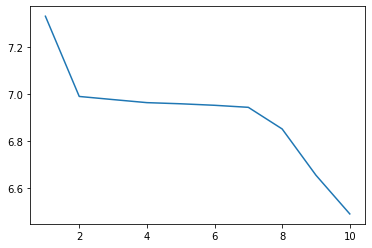

In [27]:
train(cond_lstm, batch_size=batch_size, epochs=epochs, print_every=5)

### Saving

In [74]:
torch.save(cond_lstm_w2v.state_dict(), path)

In [75]:
cond_lstm_w2v.load_state_dict(torch.load(path))

<All keys matched successfully>

In [76]:
cond_lstm_w2v.eval()

CondLSTM_Word2Vec(
  (emb_layer): Embedding(17862, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=17862, bias=True)
)

In [ ]:
for param_tensor in cond_lstm_w2v.state_dict():
    print(param_tensor, "\t", cond_lstm_w2v.state_dict()[param_tensor].size())

emb_layer.weight 	 torch.Size([17862, 100])
lstm.weight_ih_l0 	 torch.Size([1024, 100])
lstm.weight_hh_l0 	 torch.Size([1024, 256])
lstm.bias_ih_l0 	 torch.Size([1024])
lstm.bias_hh_l0 	 torch.Size([1024])
lstm.weight_ih_l1 	 torch.Size([1024, 256])
lstm.weight_hh_l1 	 torch.Size([1024, 256])
lstm.bias_ih_l1 	 torch.Size([1024])
lstm.bias_hh_l1 	 torch.Size([1024])
lstm.weight_ih_l2 	 torch.Size([1024, 256])
lstm.weight_hh_l2 	 torch.Size([1024, 256])
lstm.bias_ih_l2 	 torch.Size([1024])
lstm.bias_hh_l2 	 torch.Size([1024])
fc.weight 	 torch.Size([17862, 256])
fc.bias 	 torch.Size([17862])


## Generation

In [40]:
def word_to_id(word):
    return w2v_model.wv.key_to_index[word]

def id_to_word(id):
    return w2v_model.wv.index_to_key[id]

In [41]:
# predict next token
def predict(model, t, h=None): # default value as None for first iteration
         
    # tensor inputs
    x = np.array([[word_to_id(t)]])
    inputs = torch.from_numpy(x)

    # detach hidden state from history
    h = tuple([each.data for each in h])

    # get the output of the model
    out, h = model(inputs, h)

    # get the token probabilities
    p = F.softmax(out, dim=1).data
    
    p = p.numpy()
    p = p.reshape(p.shape[1],)

    # get indices of top n values
    top_ids = p.argsort()[-10:][::-1]

    # sample id of next word from top n values
    next_id = top_ids[random.sample([0,1,2,3,4,5,6,7,8,9],1)[0]]

    # return the value of the predicted word and the hidden state
    return id_to_word(next_id), h

In [42]:
gen_batch_size = 1

In [43]:
# PCA for generation batch size
gen_pca_topics = PCA(n_components=n_layers * gen_batch_size, svd_solver='full').fit_transform(trans_topics)
gen_pca_trans = np.transpose(gen_pca_topics)

In [44]:
# function to generate text
def generate(model=cond_lstm, n=10, prompt='in this paper'):
    
    model.eval()
    
    h = (torch.FloatTensor(gen_pca_trans.reshape(n_layers, gen_batch_size, n_hidden)),
         torch.ones(n_layers, gen_batch_size, n_hidden))

    words = prompt.split()

    # predict next token
    for t in prompt.split():
        token, h = predict(model, t, h)
    
    words.append(token)

    # predict subsequent tokens
    for i in range(n-1):
        token, h = predict(model, words[-1], h)
        words.append(token)

    return ' '.join(words)

In [45]:
generate(model=cond_lstm_w2v, n=50)

'in this paper for both english language detection in addition that there could help use both the number that language pairs the task can help use the user of natural languages we describe a framework of the task which includes the development for semeval shared shared model we introduce a neural framework based'

In [46]:
generate(model=cond_lstm_w2v, n=100, prompt='in this paper we')

'in this paper we show that such language modeling in terms for semantic classification our framework combines semantic role information of words that is used with lexical resources which makes more robust information to the same extent that are a challenging process in order of a single way we show in particular how we provide an approach and how a task for automatic speech resolution classification the task includes several language processing systems that is able that the process between languages can use a set the goal to build both data that is possible and present an approach for evaluating different strategies to be'

## Evaluation